# Module import

In [1]:
import pandas as pd
import numpy as np
import cv2
from glob import glob
import os
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as tf
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.io import read_image

#Import data

In [2]:
#import shutil

#shutil.rmtree('./CIFAKE')

In [3]:
!git clone https://github.com/jordan-bird/CIFAKE-Real-and-AI-Generated-Synthetic-Images.git CIFAKE

Cloning into 'CIFAKE'...
remote: Enumerating objects: 118688, done.
remote: Counting objects: 100% (118688/118688), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 118688 (delta 118649), reused 118673 (delta 118645), pack-reused 0
Receiving objects: 100% (118688/118688), 39.68 MiB | 29.77 MiB/s, done.
Resolving deltas: 100% (118649/118649), done.
Updating files: 100% (120001/120001), done.


## Prepare train/test data

In [4]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None, target_transform=None):
      self.img_labels = dataframe
      self.img_dir = img_dir
      self.transform = transform
      self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [5]:
def showNineImgs(data):
  # Check if data was loaded without any problems
  labels_map = {
      0: "fake",
      1: "real",
  }
  figure = plt.figure(figsize=(8, 8))
  cols, rows = 3, 3
  for i in range(1, cols * rows + 1):
      sample_idx = torch.randint(len(data), size=(1,)).item()
      img, label = data[sample_idx]
      figure.add_subplot(rows, cols, i)
      plt.title(labels_map[label])
      plt.axis("off")
      plt.imshow(img.permute(1, 2, 0).squeeze(), cmap="gray")
  plt.show()

In [6]:
TRAIN_ANNO_PATH = "train_labels.csv"

train_paths_fake = list(glob('./CIFAKE/DATASET/train/FAKE/*.jpg'))
print(len(train_paths_fake))

df_train_fake = pd.DataFrame(train_paths_fake)
df_train_fake.columns = ['path']
df_train_fake['label'] = 0
df_train_fake.head()

train_paths_real = list(glob('./CIFAKE/DATASET/train/REAL/*.jpg'))
print(len(train_paths_real))

df_train_real = pd.DataFrame(train_paths_real)
df_train_real.columns = ['path']
df_train_real['label'] = 1
df_train_real.head()

df_train = pd.concat((df_train_fake, df_train_real), axis = 0 )
print(df_train.shape)

df_train.to_csv(TRAIN_ANNO_PATH, index=False)

50000
50000
(100000, 2)


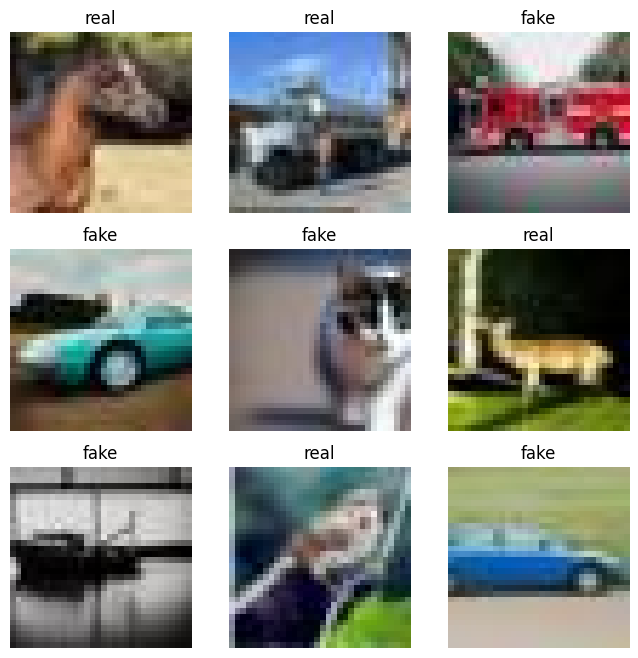

In [7]:
training_data = CustomImageDataset(pd.read_csv(TRAIN_ANNO_PATH), "", transform=lambda img: img.type(torch.FloatTensor) / 255)
showNineImgs(training_data)

In [8]:
TEST_ANNO_PATH = "test_labels.csv"

test_paths_fake = list(glob('./CIFAKE/DATASET/test/FAKE/*.jpg'))
print(len(test_paths_fake))

df_test_fake = pd.DataFrame(test_paths_fake)
df_test_fake.columns = ['path']
df_test_fake['label'] = 0
df_test_fake.head()

test_paths_real = list(glob('./CIFAKE/DATASET/test/REAL/*.jpg'))
print(len(test_paths_real))

df_test_real = pd.DataFrame(test_paths_real)
df_test_real.columns = ['path']
df_test_real['label'] = 1
df_test_real.head()

df_test = pd.concat((df_test_fake, df_test_real), axis = 0 )
print(df_test.shape)

df_test.to_csv(TEST_ANNO_PATH, index=False)

10000
10000
(20000, 2)


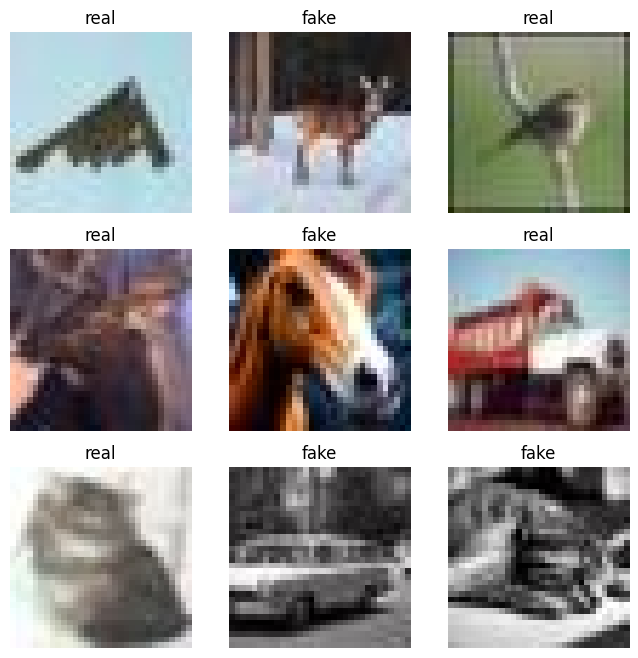

In [9]:
test_data = CustomImageDataset(pd.read_csv(TEST_ANNO_PATH), "", transform=lambda img: img.type(torch.FloatTensor) / 255)
showNineImgs(test_data)

## Model

In [10]:
# model from https://www.kaggle.com/code/muntasirfahimniloy/simple-cnn-on-cifake-90-acc

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)     # output: [32, 32, 32]
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)    # output: [64, 32, 32]
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)   # output: [128, 32, 32]
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 2)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))    # [32, 16, 16]
        x = self.pool(F.relu(self.conv2(x)))    # [64, 8, 8]
        x = self.pool(F.relu(self.conv3(x)))    # [128, 4, 4]
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.dropout(x)     # dropout for regularization
        x = F.sigmoid(self.fc2(x))
        return x

In [11]:
# Initialize the weights of the model
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

# Check for GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")




### Sanity check

In [12]:
# Assuming train_loader provides batches of input data and corresponding labels
# Use a very small subset of your training data for the sanity check

overfit_subset_size = 50  # Choose a small subset size

# Load a small subset of your training data
overfit_train_loader = DataLoader(training_data, batch_size=16, shuffle=True)
overfit_subset = []
for idx, (inputs, labels) in enumerate(overfit_train_loader):
    overfit_subset.append((inputs, labels))
    if idx + 1 >= overfit_subset_size:
        break

# Unpack inputs and labels from the subset
overfit_inputs, overfit_labels = zip(*overfit_subset)
overfit_inputs = torch.cat(overfit_inputs, dim=0)[:overfit_subset_size]  # Concatenate and limit to subset_size
overfit_labels = torch.cat(overfit_labels, dim=0)[:overfit_subset_size]  # Limit to subset_size

# Move data to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
overfit_inputs = overfit_inputs.to(device)
overfit_labels = overfit_labels.to(device)
overfit_model = SimpleCNN()
overfit_model.apply(weights_init)
overfit_model.to(device)

# Define loss function and optimizer
overfit_criterion = nn.CrossEntropyLoss()
overfit_optimizer = optim.Adam(overfit_model.parameters(), lr=0.0001)



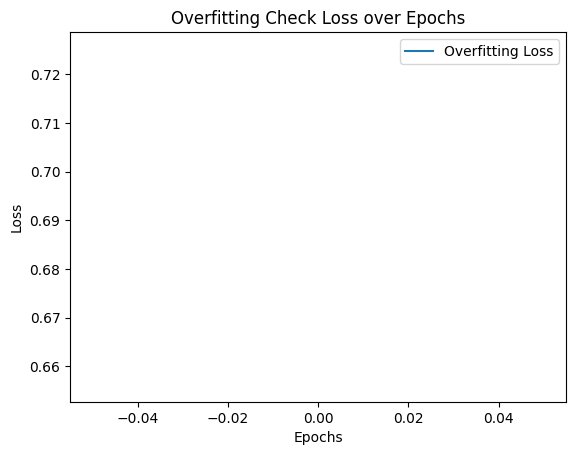

In [13]:
# Train the model on the small subset multiple times (overfitting intentionally)
overfit_epochs = 1  # Number of epochs for overfitting check

overfit_losses = []  # To track losses during training

for epoch in range(overfit_epochs):
    overfit_optimizer.zero_grad()  # Zero gradients
    overfit_outputs = overfit_model(overfit_inputs)  # Forward pass
    overfit_loss = overfit_criterion(overfit_outputs, overfit_labels)  # Calculate loss
    overfit_loss.backward()  # Backpropagation
    overfit_optimizer.step()  # Update weights

    overfit_losses.append(overfit_loss.item())  # Record the loss

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{overfit_epochs}], Loss: {overfit_loss.item():.4f}")

# Plot the loss curve
import matplotlib.pyplot as plt

plt.plot(range(overfit_epochs), overfit_losses, label='Overfitting Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Overfitting Check Loss over Epochs')
plt.legend()
plt.show()

In [14]:
NUM_EPOCHS = 30
BATCH_SIZE = 64

In [15]:
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)

model = SimpleCNN()
model.apply(weights_init)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [16]:
losses = []

model.train()
# Assuming train_loader provides batches of input data and corresponding labels
for epoch in range(NUM_EPOCHS):
    epoch_loss = 0.0  # Initialize epoch loss
    for i, data in enumerate(train_dataloader, start=0):
        inputs, labels = data  # Get inputs and corresponding labels

        # Move inputs and labels to the GPU
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights based on gradients

        # Accumulate epoch loss
        epoch_loss += loss.item()

        # Optionally, print the loss
        if i % 200 == 0:
            print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Batch [{i+1}/{len(train_dataloader)}], Loss: {loss.item():.4f}")

    # Calculate average epoch loss and store it
    avg_epoch_loss = epoch_loss / len(train_dataloader)
    losses.append(avg_epoch_loss)

    if epoch % 10 == 0:
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Average Epoch Loss: {avg_epoch_loss:.4f}")


Epoch [1/30], Batch [1/1563], Loss: 0.6967
Epoch [1/30], Batch [201/1563], Loss: 0.5956
Epoch [1/30], Batch [401/1563], Loss: 0.5133
Epoch [1/30], Batch [601/1563], Loss: 0.4380
Epoch [1/30], Batch [801/1563], Loss: 0.4156
Epoch [1/30], Batch [1001/1563], Loss: 0.4268
Epoch [1/30], Batch [1201/1563], Loss: 0.4380
Epoch [1/30], Batch [1401/1563], Loss: 0.4593
Epoch [1/30], Average Epoch Loss: 0.4517
Epoch [2/30], Batch [1/1563], Loss: 0.3961
Epoch [2/30], Batch [201/1563], Loss: 0.3769
Epoch [2/30], Batch [401/1563], Loss: 0.3688
Epoch [2/30], Batch [601/1563], Loss: 0.3630
Epoch [2/30], Batch [801/1563], Loss: 0.4163
Epoch [2/30], Batch [1001/1563], Loss: 0.4065
Epoch [2/30], Batch [1201/1563], Loss: 0.4033
Epoch [2/30], Batch [1401/1563], Loss: 0.4735
Epoch [3/30], Batch [1/1563], Loss: 0.4697
Epoch [3/30], Batch [201/1563], Loss: 0.3726
Epoch [3/30], Batch [401/1563], Loss: 0.3860
Epoch [3/30], Batch [601/1563], Loss: 0.3953
Epoch [3/30], Batch [801/1563], Loss: 0.4128
Epoch [3/30], 

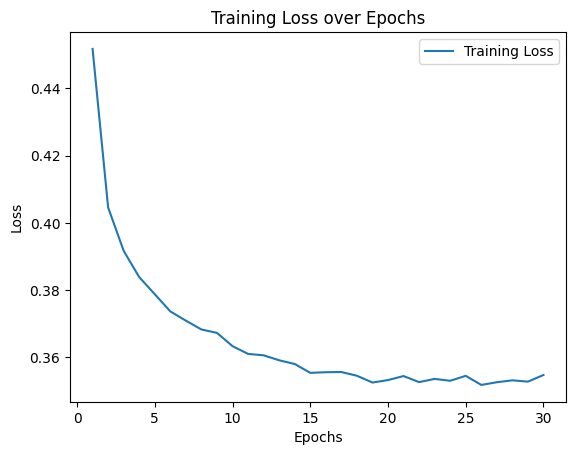

In [18]:
# Plotting the loss
plt.plot(range(1, NUM_EPOCHS + 1), losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()


### Save the model at my google drive

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
!ls

CIFAKE	drive  sample_data  test_labels.csv  train_labels.csv


In [23]:
torch.save(model.state_dict(), './drive/MyDrive/Github/COSE474_Term_Project/model_weights.pth')

### Test the model

In [25]:
# Load the trained model
#model = SimpleCNN()
#model.load_state_dict(torch.load('./drive/MyDrive/Github/COSE474_Term_Project/model_weights.pth'))
model.eval()

# Prepare the test dataset
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

# Evaluate the model
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:

        # Move inputs and labels to the GPU
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Accuracy on the test dataset: {accuracy}')

Accuracy on the test dataset: 0.94475
